# Alternating Least Squares (ALS)

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть решуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать прост оперемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

## Базовое применение

In [6]:
import warnings
from metrics import precision, recall
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import pandas as pd
import numpy as np
warnings.simplefilter('ignore')

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

In [9]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                     'product_id': 'item_id'},
            inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [10]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [11]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [12]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns = ['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [13]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values(
    'n_sold', ascending=False).head(5000).item_id.tolist()

In [14]:
data_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [15]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values='quantity',  # Можно пробовать другие варианты
                                  aggfunc='count',
                                  fill_value=0
                                  )

user_item_matrix = user_item_matrix.astype(
    float)  # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

***********************************

# Тест параметров ALS

## N factors test

In [48]:
# TF-IDF взвешивание
# Применяется к item-user матрице !
sparse_user_item_tfidf = tfidf_weight(user_item_matrix.T).T

# BM25 взвешивание
# Применяется к item-user матрице !
user_item_matrix_bm25 = bm25_weight(user_item_matrix.T).T

In [62]:
score_dict = {}
for n, matrix in enumerate([user_item_matrix, sparse_user_item_tfidf, user_item_matrix_bm25], 1):
    score_list = []
    for factors in range(20, 201, 20):
        model = AlternatingLeastSquares(factors=factors,
                                        regularization=0.001,
                                        iterations=15,
                                        calculate_training_loss=True,
                                        num_threads=4,
                                        random_state=13)

        model.fit(csr_matrix(matrix).T,  # На вход item-user matrix
                  show_progress=False)

        result['als'] = result['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in
                                                           model.recommend(userid=userid_to_id[x],
                                                                           user_items=sparse_user_item,   # на вход user-item matrix
                                                                           N=5,
                                                                           filter_already_liked_items=False,
                                                                           filter_items=[
                                                                               itemid_to_id[999999]],
                                                                           recalculate_user=True)])

        score = result.apply(lambda row: precision(
            row['als'], row['actual'], 5), axis=1).mean()
#         result.drop(columns='als', inplace=True)
        score_list.append(score)
    score_dict[n] = score_list

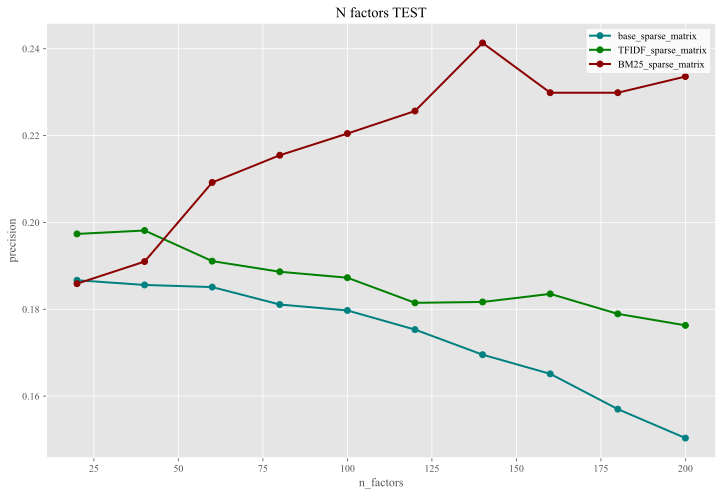

In [66]:
plt.figure(figsize=(12, 8))
plt.xlabel('n_factors')
plt.ylabel('precision')
plt.title('N factors TEST')
plt.plot(range(20, 201, 20), score_dict[1], color='teal',
         marker='o',  linewidth=2, label='base_sparse_matrix')
plt.plot(range(20, 201, 20), score_dict[2], color='g',
         marker='o', linewidth=2, label='TFIDF_sparse_matrix')
plt.plot(range(20, 201, 20), score_dict[3], color='darkred',
         marker='o', linewidth=2, label='BM25_sparse_matrix')
plt.legend(loc='best', facecolor='white')
plt.show()

## Regularization test

In [68]:
score_dict = {}
for n, matrix in enumerate([user_item_matrix, sparse_user_item_tfidf, user_item_matrix_bm25], 1):
    score_list = []
    for reg in (np.linspace(0.001, 0.2, 20)):
        model = AlternatingLeastSquares(factors=100,
                                        regularization=reg,
                                        iterations=15,
                                        calculate_training_loss=True,
                                        num_threads=4,
                                        random_state=13)

        model.fit(csr_matrix(matrix).T,  # На вход item-user matrix
                  show_progress=False)

        result['als'] = result['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in
                                                           model.recommend(userid=userid_to_id[x],
                                                                           user_items=sparse_user_item,   # на вход user-item matrix
                                                                           N=5,
                                                                           filter_already_liked_items=False,
                                                                           filter_items=[
                                                                               itemid_to_id[999999]],
                                                                           recalculate_user=True)])

        score = result.apply(lambda row: precision(
            row['als'], row['actual'], 5), axis=1).mean()
        score_list.append(score)
    score_dict[n] = score_list

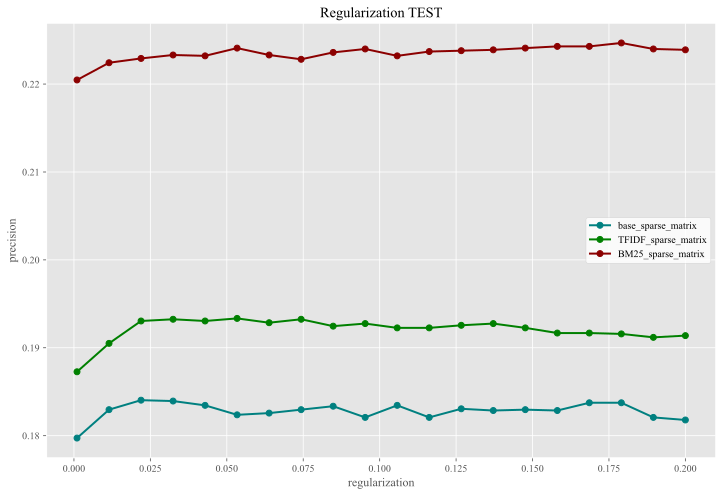

In [69]:
plt.figure(figsize=(12, 8))
plt.xlabel('regularization')
plt.ylabel('precision')
plt.title('Regularization TEST')
plt.plot(np.linspace(0.001, 0.2, 20),
         score_dict[1], color='teal', marker='o',  linewidth=2, label='base_sparse_matrix')
plt.plot(np.linspace(0.001, 0.2, 20),
         score_dict[2], color='g', marker='o', linewidth=2, label='TFIDF_sparse_matrix')
plt.plot(np.linspace(0.001, 0.2, 20),
         score_dict[3], color='darkred', marker='o', linewidth=2, label='BM25_sparse_matrix')

plt.legend(loc='best', facecolor='white')
plt.show()

## SEARCH PARAMS

In [72]:
score_dict = {}
for factors in range(100, 161, 10):
    for reg in (np.linspace(0.05, 0.22, 10)):
        model = AlternatingLeastSquares(factors=factors,
                                        regularization=reg,
                                        iterations=15,
                                        calculate_training_loss=True,
                                        num_threads=4,
                                        random_state=13)

        model.fit(csr_matrix(user_item_matrix_bm25).T,  # На вход item-user matrix
                  show_progress=False)

        result['als'] = result['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in
                                                           model.recommend(userid=userid_to_id[x],
                                                                           user_items=sparse_user_item,   # на вход user-item matrix
                                                                           N=5,
                                                                           filter_already_liked_items=False,
                                                                           filter_items=[
                                                                               itemid_to_id[999999]],
                                                                           recalculate_user=True)])

        score = result.apply(lambda row: precision(
            row['als'], row['actual'], 5), axis=1).mean()

        score_dict[f'fac{factors}_reg{round(reg,3)}'] = score

-----

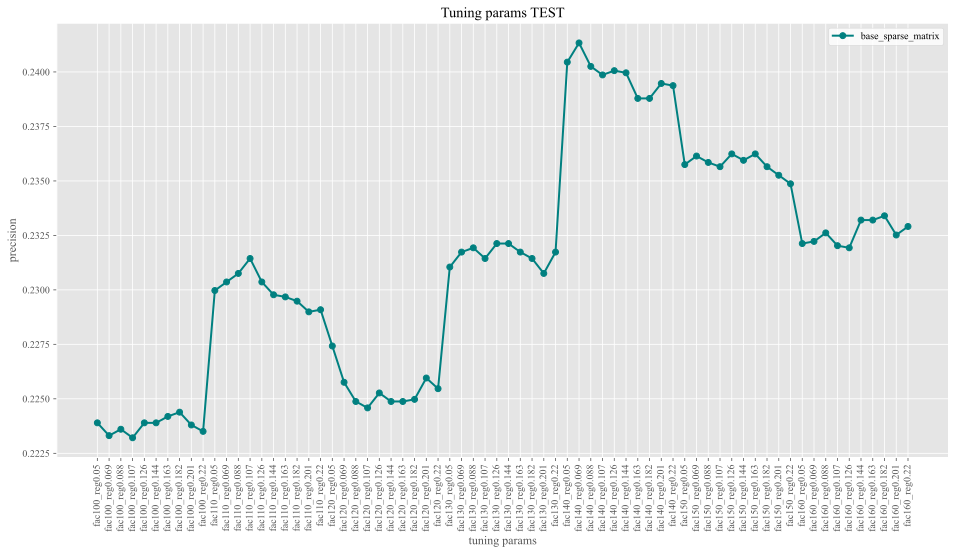

In [73]:
plt.figure(figsize=(16, 8))
plt.xlabel('tuning params')
plt.ylabel('precision')
plt.title('Tuning params TEST')
plt.plot(score_dict.keys(), score_dict.values(), color='teal',
         marker='o',  linewidth=2, label='base_sparse_matrix')
plt.xticks(rotation=90)
plt.legend(loc='best', facecolor='white')
plt.show()

*******************************

## Фильтр товаров

In [75]:
def prefilter_items(data: pd.DataFrame,
                    group_col: str=None,
                    popular_col: str=None,
                    time_col: str=None,
                    price_col: str=None,
                    top_popular_filter: int = None,
                    top_unpopular_filter: int = None,
                    time_unpopular_filter: int = None,
                    chip_item_filter: int = None,
                    exp_item_filter: int = None) -> pd.DataFrame:

    n_filter_start = (data_train['item_id'] == 999999).sum()

    if top_popular_filter:  # фильтр самых популярных товаров

        popularity = data_train.groupby(
            group_col)[popular_col].sum().reset_index()
        top = popularity.sort_values(popular_col, ascending=False).head(
            top_popular_filter).item_id.tolist()
        data.loc[data[group_col].isin(top), group_col] = 999999

    if top_unpopular_filter:  # фильтр самых популярных товаров

        bottom = popularity.sort_values(
            popular_col, ascending=True).head(top_unpopular_filter).item_id.tolist()
        data.loc[data[group_col].isin(bottom), group_col] = 999999

    if time_unpopular_filter:  # фильтр товаров, которые не продавались за последние N месяцев

        actuality = data.groupby(group_col)[time_col].min().reset_index()
        top_actual = actuality[actuality[time_col] > 365].item_id.tolist()
        data.loc[data[group_col].isin(top_actual), group_col] = 999999

    if chip_item_filter:  # Фильт товаров, которые стоят < N$

        low_price = data[data[price_col] < chip_item_filter].item_id.tolist()
        data.loc[data[group_col].isin(low_price), group_col] = 999999

    if exp_item_filter:  # Фильт товаров, которые стоят > N$ (дорогих)

        high_price = data[data[price_col] > exp_item_filter].item_id.tolist()
        data.loc[data[group_col].isin(high_price), group_col] = 999999

    n_filter = (data_train['item_id'] == 999999).sum() - n_filter_start
    print(f'Отфильтровано {n_filter} записей')

    return data

In [76]:
data_train = prefilter_items(data_train, group_col='item_id',
                             popular_col='quantity',
                             time_col='day',
                             price_col='sales_value',
                             top_popular_filter=5,
                             top_unpopular_filter=200,
                             time_unpopular_filter=365,
                             chip_item_filter=1,
                             exp_item_filter=600)

Отфильтровано 1114680 записей
